In [2]:
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

import pandas as pd

Simulate 3D data

In [135]:
import scipy.integrate as sint

sigma = 10.
beta = 8./3.
rho = 28.

def deriv( state, t ):
    x = state[0]
    y = state[1]
    z = state[2]
    
    dx = sigma * (y - x)
    if t >= 200 and t < 400:
        dx += 15.
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    
    return np.array( [dx, dy, dz] )

t_eval = np.arange( 0, 1000, 0.05 )
state_0 = np.array( [1, 0, 0] )
fs = 1. / (t_int[1] - t_int[0])

states = sint.odeint( deriv, state_0, t_eval )

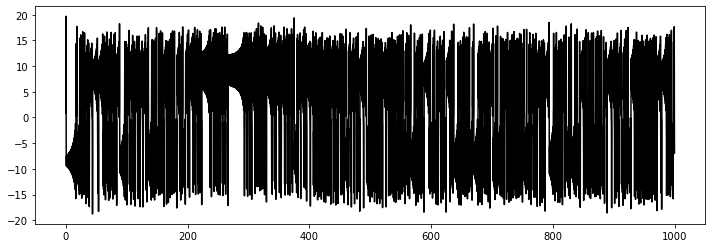

In [136]:
plt.figure( figsize = (12, 4) )
plt.plot( t_eval, states[:, 0], 'k-' )
plt.show()

Generate noisy observations from this

In [137]:
A = np.array( [ [1., 0.3, 0.7],
                [0., 1.2, 0.2],
                [0.2, 0.2, 1.4],
                [1.7, 0.8, 2.1],
                [0.4, 1.4, 0.1],
                [0.1, 0.1, 0.1] ] )

observed_raw = (A @ states.T).T

noise_level = 10
noise = noise_level * np.random.normal( size = observed_raw.shape )

observed = noise + observed_raw
n_channels_observed = observed.shape[1]

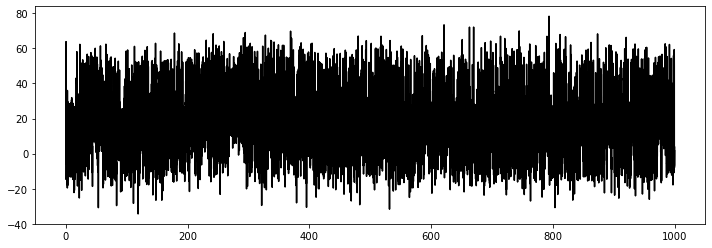

In [138]:
plt.figure( figsize = (12, 4) )
plt.plot( t_eval, observed[:, 0], 'k-' )
plt.show()

In [139]:
ar_order = 10

In [158]:
exog_raw = ((t_eval >= 200) & (t_eval < 400)).astype( float )

n_back = 3000
back_skip = 20
exog = np.zeros( (exog_raw.shape[0], n_back // back_skip) )
for ii, i in enumerate( range( back_skip, n_back + 1, back_skip ) ):
    exog[i:, ii] = exog_raw[:-i]
    
n_exog = exog.shape[1]

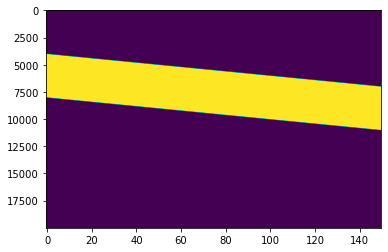

In [159]:
plt.imshow( exog, aspect = 'auto' )

In [160]:
import statsmodels.tsa.vector_ar.var_model as var

model = var.VAR( observed,
                 exog = exog )
results = model.fit( maxlags = ar_order )

Impulse response of one channel on another

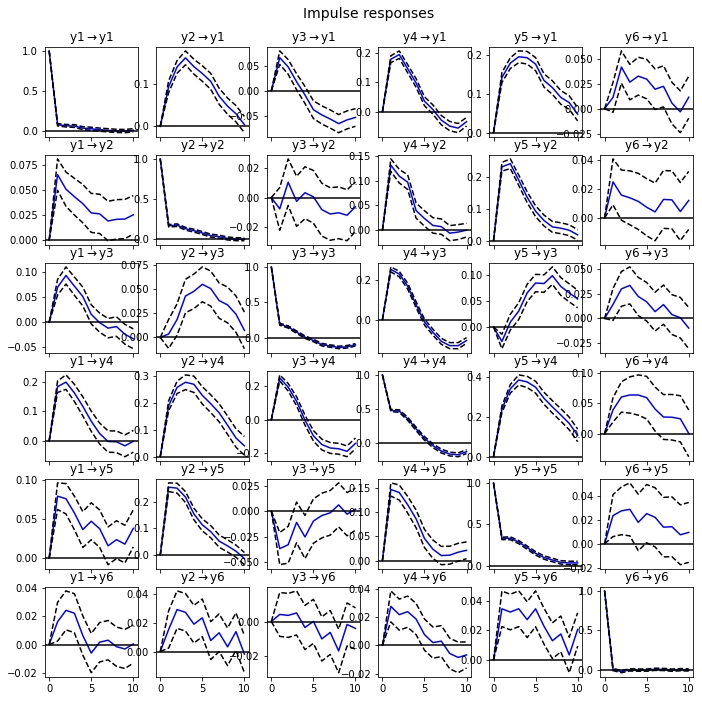

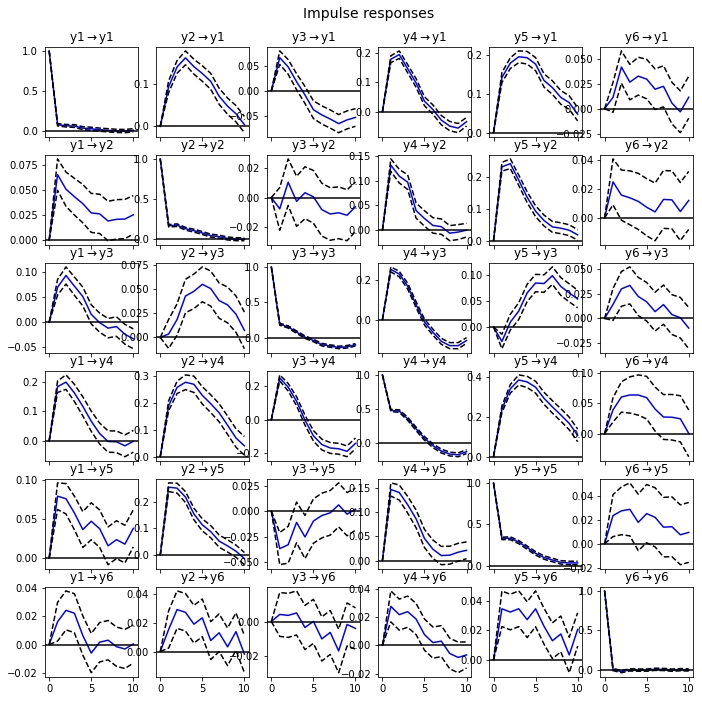

In [161]:
irf = results.irf( ar_order )
irf.plot( orth = False )

Extract coefficient matrices

In [165]:
coefs = np.zeros( (n_channels_observed, n_channels_observed, ar_order) )
for to_channel in range( n_channels_observed ):
    cur_param = n_exog + 1
    for cur_order in range( ar_order ):
        for from_channel in range( n_channels_observed ):
            coefs[to_channel, from_channel, cur_order] = results.params[cur_param, to_channel]
            cur_param += 1

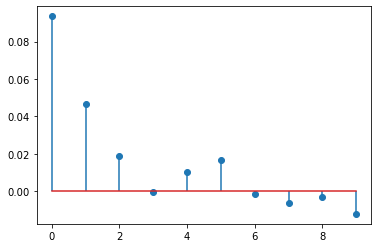

In [166]:
to_channel = 0
from_channel = 1

cur_coefs = coefs[to_channel, from_channel, :]
plt.stem( cur_coefs )
plt.show()

Granger causality

In [167]:
import scipy.signal as sig
cur_coefs_fourier_f, cur_coefs_fourier = sig.freqz( cur_coefs, fs = fs )

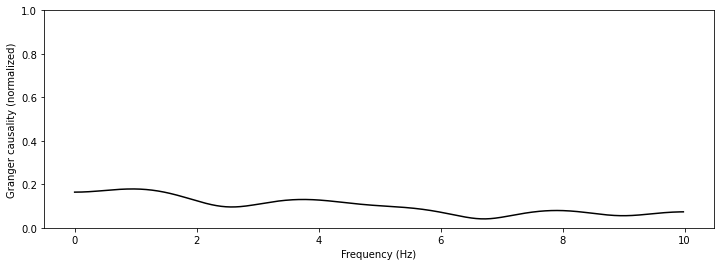

In [168]:
plt.figure( figsize = (12, 4) )
plt.plot( cur_coefs_fourier_f, np.abs( cur_coefs_fourier ), 'k-' )
plt.ylim( 0, 1 )
plt.xlabel( 'Frequency (Hz)' )
plt.ylabel( 'Granger causality (normalized)' )
plt.show()